Loading Neccessary Packages

In [1]:
"""Submitted by Sivaramakrishnan Sridharan, Srinivasan Rajagopal and Indrajith Shanmugasundaram"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import zipfile
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.models as models
import time

Loading the dataset

# New Section

In [2]:
"""Extracting files from Zip file"""
from zipfile import ZipFile
file_name = 'Cam101.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()

Number of training samples: 180
Random training images with their masks


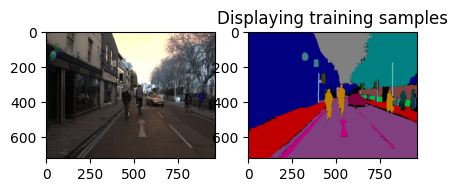

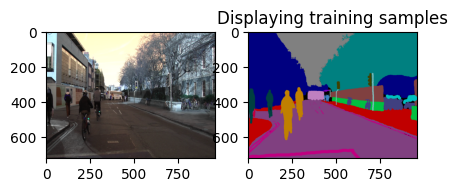

Number of testing samples: 22
Random testing images with their masks


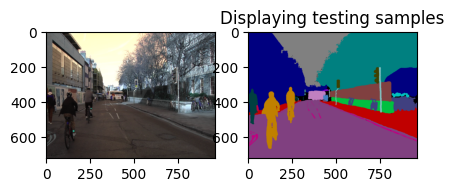

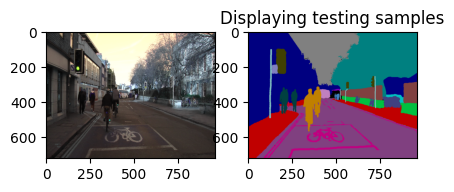

In [3]:
"""Splitting images list and mask list seperately and visulaizing few random samples"""
train_folder = "/content/Cam101/train"
test_folder = "/content/Cam101/test"
train_images_folder = []
train_mask_folder = []

# Separating train images list and mask list
for filename in os.listdir(train_folder):
  if filename.endswith('_L.png'):
    train_mask_folder.append(train_folder+'/'+filename)
  else:
    train_images_folder.append(train_folder+'/'+filename)
train_mask_folder.sort()
train_images_folder.sort()
random_training_samples = np.random.choice(range(len(train_images_folder)), size = 2, replace = False)
print("Number of training samples:", len(os.listdir(train_folder)))

print("Random training images with their masks")
# Visualizing 2 random train images and their masks
for i in range(len(random_training_samples)):
  plt.figure(figsize=(10, 5))
  plt.subplot(2, 2*len(random_training_samples), i+1)
  plt.imshow(cv2.imread(train_images_folder[random_training_samples[i]]))
  plt.subplot(2, 2*len(random_training_samples), i+2)
  plt.imshow(cv2.imread(train_mask_folder[random_training_samples[i]]))
  plt.title('Displaying training samples')
  plt.show()

test_images_folder = []
test_mask_folder = []

# Separating test images list and mask list
for filename in os.listdir(test_folder):
  if filename.endswith('_L.png'):
    test_mask_folder.append(test_folder+'/'+filename)
  else:
    test_images_folder.append(test_folder+'/'+filename)
test_mask_folder.sort()
test_images_folder.sort()
random_testing_samples = np.random.choice(range(len(test_images_folder)), size = 2, replace = False)
print("Number of testing samples:", len(os.listdir(test_folder)))

print("Random testing images with their masks")
# Visualizing 2 random test images and their masks
for i in range(len(random_testing_samples)):
  plt.figure(figsize=(10, 5))
  plt.subplot(2, 2*len(random_testing_samples), i+1)
  plt.imshow(cv2.imread(test_images_folder[random_testing_samples[i]]))
  plt.subplot(2, 2*len(random_testing_samples), i+2)
  plt.imshow(cv2.imread(test_mask_folder[random_testing_samples[i]]))
  plt.title('Displaying testing samples')
  plt.show()

In [4]:
"""Mapping rgb value to the class names and class indices"""
label_mapping = "/content/Cam101/label_colors.txt"

mapping = {}  # Dictionary to store the RGB class names mapping
mapping_index = {} # Dictionary to store the RGB class indices mapping
counter = 0

with open(label_mapping, 'r') as f:
    for line in f:
        # Converting bgr to rgb values to match the one given in mapping file
        rgb = (int(line.strip().split()[2]), int(line.strip().split()[1]), int(line.strip().split()[0]))
        class_name = line.strip().split()[-1]
        mapping[rgb] = class_name
        mapping_index[rgb] = counter
        counter += 1

Visualizing random augmented images with the masks


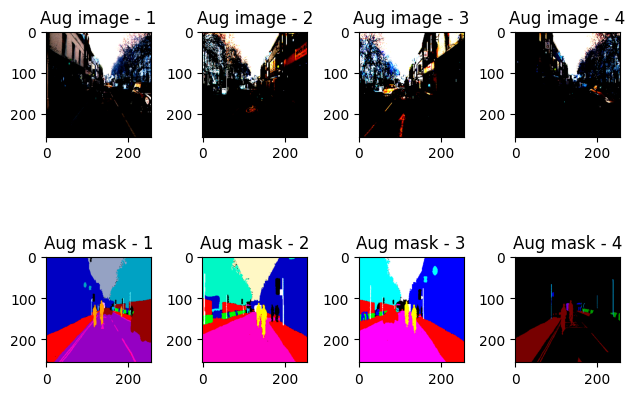

Total number of augmented images: 360


In [5]:
"""Augmenting images and the masks and visualizing few random samples"""

# The values mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] are taken from Resnet trained model to give better accuracies
augmentation = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Tuning augmentation to visualize the different augmented images
augmentation1 = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.35, 0.33, 0.31], std=[0.26, 0.27, 0.25]),
    ToTensorV2()
])
augmentation2 = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.Normalize(mean=[0.31, 0.33, 0.35], std=[0.1, 0.1, 0.1]),
    ToTensorV2()
])
augmentation3 = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=1),
    A.Normalize(mean=[0.35, 0.35, 0.35], std=[0.05, 0.05, 0.05]),
    ToTensorV2()
])
augmentation4 = A.Compose([
    A.Resize(256, 256),
    A.RandomBrightnessContrast(p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

aug_data_list = []
for index in range(len(train_images_folder)):
    # Augmenting images on different parame
    image = cv2.imread(train_images_folder[index])
    mask = cv2.imread(train_mask_folder[index])

    augmented_mask = augmentation1(image = mask)["image"]
    augmented_image = augmentation1(image = image)["image"]
    aug_data_list.append((augmented_image, augmented_mask))

    augmented_mask = augmentation2(image = mask)["image"]
    augmented_image = augmentation2(image = image)["image"]
    aug_data_list.append((augmented_image, augmented_mask))

    augmented_mask = augmentation3(image = mask)["image"]
    augmented_image = augmentation3(image = image)["image"]
    aug_data_list.append((augmented_image, augmented_mask))

    augmented_mask = augmentation4(image = mask)["image"]
    augmented_image = augmentation4(image = image)["image"]
    aug_data_list.append((augmented_image, augmented_mask))

print("Visualizing random augmented images with the masks")
fig, axes = plt.subplots(nrows=2, ncols=4) 
random_training_samples = np.random.choice(range(len(train_images_folder)), size = 4, replace = False)
# for j in range(len(random_training_samples)):
image = cv2.imread(train_images_folder[random_training_samples[0]])
mask = cv2.imread(train_mask_folder[random_training_samples[0]])
augmented_mask = augmentation1(image = mask)["image"]
augmented_image = augmentation1(image = image)["image"]
image_data = np.transpose(augmented_image, (1, 2, 0))
mask_data = np.transpose(augmented_mask, (1, 2, 0))
axes[0,0].imshow(image_data)
axes[0,0].set_title('Aug image - 1')
axes[1,0].imshow(mask_data)
axes[1,0].set_title('Aug mask - 1')

image = cv2.imread(train_images_folder[random_training_samples[1]])
mask = cv2.imread(train_mask_folder[random_training_samples[1]])
augmented_mask = augmentation2(image = mask)["image"]
augmented_image = augmentation2(image = image)["image"]
image_data = np.transpose(augmented_image, (1, 2, 0))
mask_data = np.transpose(augmented_mask, (1, 2, 0))
axes[0,1].imshow(image_data)
axes[0,1].set_title('Aug image - 2')
axes[1,1].imshow(mask_data)
axes[1,1].set_title('Aug mask - 2')

image = cv2.imread(train_images_folder[random_training_samples[2]])
mask = cv2.imread(train_mask_folder[random_training_samples[2]])
augmented_mask = augmentation3(image = mask)["image"]
augmented_image = augmentation3(image = image)["image"]
image_data = np.transpose(augmented_image, (1, 2, 0))
mask_data = np.transpose(augmented_mask, (1, 2, 0))
axes[0,2].imshow(image_data)
axes[0,2].set_title('Aug image - 3')
axes[1,2].imshow(mask_data)
axes[1,2].set_title('Aug mask - 3')

image = cv2.imread(train_images_folder[random_training_samples[3]])
mask = cv2.imread(train_mask_folder[random_training_samples[3]])
augmented_mask = augmentation4(image = mask)["image"]
augmented_image = augmentation4(image = image)["image"]
image_data = np.transpose(augmented_image, (1, 2, 0))
mask_data = np.transpose(augmented_mask, (1, 2, 0))
axes[0,3].imshow(image_data)
axes[0,3].set_title('Aug image - 4')
axes[1,3].imshow(mask_data)
axes[1,3].set_title('Aug mask - 4')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()
# Display the total number of augmented images
num_augmented_images = len(aug_data_list)
print("Total number of augmented images:", num_augmented_images)

In [6]:
"""Creating custom dataset which returns class indices for each pixel value of an augmented image"""
class CustomDataset(Dataset):
    def __init__(self, images_folder, mask_folder, mapping):
        self.images_folder = images_folder
        self.mask_folder = mask_folder
        self.mapping = mapping

    def __len__(self):
        return len(self.images_folder)

    def __getitem__(self, idx):
        image = cv2.imread(self.images_folder[idx])
        label = cv2.imread(self.mask_folder[idx])

        # Assigning class labels to each pixels of each images
        pixel_classindex = np.zeros(label.shape[:-1])
        for rgb_tuple, class_index in self.mapping.items():
            mask = np.all(label == rgb_tuple, axis=2)
            pixel_classindex[mask] = class_index

        # Augmenting each images
        augmented = augmentation(image=image, mask=pixel_classindex)
        image_augmented = augmented['image']
        pixel_classindex_augmented = augmented['mask']
        return image_augmented, pixel_classindex_augmented


# Create custom datasets by inputting images and mask folder and returning image and each pixels class indices 
train_dataset = CustomDataset(train_images_folder, train_mask_folder, mapping_index)
test_dataset = CustomDataset(test_images_folder, test_mask_folder, mapping_index)
train_size = int(0.9 * len(train_dataset))
validation_size = int(0.1 * len(train_dataset))

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Print number of samples in datasets
print("Number of samples in the train dataset:", len(train_dataset))
print("Number of samples in the train dataset:", len(validation_dataset))
print("Number of sapmles in the test dataset:", len(test_dataset))

# Print samples from train loader
images, labels = next(iter(train_loader))
print("Train images shape:", images.shape)
print("Train. labels shape:", labels.shape)
# Print samples from validation loader
images, labels = next(iter(validation_loader))
print("Validation images shape:", images.shape)
print("Validation labels shape:", labels.shape)
# Print samples from test loader
images, labels = next(iter(test_loader))
print("Test images shape:",images.shape)
print("Test labels shape:",labels.shape)

Number of samples in the train dataset: 81
Number of samples in the train dataset: 9
Number of sapmles in the test dataset: 11
Train images shape: torch.Size([16, 3, 256, 256])
Train. labels shape: torch.Size([16, 256, 256])
Validation images shape: torch.Size([9, 3, 256, 256])
Validation labels shape: torch.Size([9, 256, 256])
Test images shape: torch.Size([11, 3, 256, 256])
Test labels shape: torch.Size([11, 256, 256])


In [8]:
"""Defining parameters and setting values of hyperparameters"""
neurons_size = 128
rate = 0.001
no_epochs = 10
batch = 16
no_classes = 32
loss_function = nn.CrossEntropyLoss()

# Tuning hyperparameters
params = {
    'learning_rate': [0.01, 0.1, 1, 10],
    'optimizer': [optim.Adam, optim.RMSprop, optim.Adagrad],
    'loss_function': [nn.CrossEntropyLoss, nn.TripletMarginWithDistanceLoss, nn.BCELoss]}

In [9]:
""""Implementing Fully Convolution network and iterating for 10 epochs"""
class FCN16(nn.Module):
    def __init__(self, no_classes):
        super(FCN16, self).__init__()
        # Loading the pre-trained ResNet101 model and freeze its parameters
        resnet_model = models.resnet101(pretrained=True)
        resnet_model.fc = nn.Identity()  
        resnet_model.avgpool = nn.Identity()  
        # Setting to freeze all layers and then will unfreeze the required layers
        for param in resnet_model.parameters():
            param.requires_grad = False

        # Introducing our layer in place of frozen layers
        base_layers = list(resnet_model.children())[:-2]
        self.base = nn.Sequential(*base_layers)
        self.conv = nn.Conv2d(16*neurons_size, 4*neurons_size, kernel_size=2, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.score_fr = nn.Conv2d(4*neurons_size, no_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(no_classes, no_classes, kernel_size=32, stride=16, bias=False)
        # Get weights from bilinear kernel
        kernel_size = 32
        factor = (kernel_size + 1) // 2
        center = kernel_size / 2
        x = np.arange(kernel_size).reshape(1, -1)
        y = np.arange(kernel_size).reshape(-1, 1)
        horizontal_filter = (1 - np.abs(x - center) / factor)
        vertical_filter = (1 - np.abs(y - center) / factor)
        bilinear_filter =  horizontal_filter * vertical_filter
        weight = np.zeros((no_classes, no_classes, kernel_size, kernel_size), dtype=np.float32)
        weight[np.arange(no_classes), np.arange(no_classes), :, :] = bilinear_filter
        bilinear_weight = torch.from_numpy(weight)
        with torch.no_grad():
          self.upscore.weight.copy_(bilinear_weight)

        # Unfreeze the last two residual blocks of the base model
        for module in self.base[-1][-2:]:
            for param in module.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Apply our base model from resnet model
        x = self.base(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

# Initialize the model and setting parameters
model = FCN16(no_classes)
criterion = loss_function
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=rate)
optimizer = Adam_optimizer

# Training the FCN model
for epoch in range(1, no_epochs+1):
    losses = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
      
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0

loss_function = nn.CrossEntropyLoss()
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 72.9MB/s]


Epoch -  1 / 10 --- Step - 6 --- Mean Loss - 1.6535813609759014
Epoch -  2 / 10 --- Step - 6 --- Mean Loss - 0.8213762839635214
Epoch -  3 / 10 --- Step - 6 --- Mean Loss - 0.6638368467489878
Epoch -  4 / 10 --- Step - 6 --- Mean Loss - 0.5807361801465353
Epoch -  5 / 10 --- Step - 6 --- Mean Loss - 0.5116149187088013
Epoch -  6 / 10 --- Step - 6 --- Mean Loss - 0.4890262285868327
Epoch -  7 / 10 --- Step - 6 --- Mean Loss - 0.45328982174396515
Epoch -  8 / 10 --- Step - 6 --- Mean Loss - 0.4249855726957321
Epoch -  9 / 10 --- Step - 6 --- Mean Loss - 0.4035319934288661
Epoch -  10 / 10 --- Step - 6 --- Mean Loss - 0.38162851333618164


In [ ]:
"""Validate FCN Model"""
def calculate_iou(outputs, labels):
    Smooth = 1e-6
    intersection = torch.logical_and(outputs, labels).sum((1, 2)).float()
    union = torch.logical_or(outputs, labels).sum((1, 2)).float()
    iou = (intersection + Smooth) / (union + Smooth)
    mean_iou = iou.mean()
    return mean_iou

model = FCN16(no_classes)
criterion = loss_function
optimizer = Adam_optimizer
best_model = None
best_iou = 0.0
best_pixel_accuracy = 0.0

train_losses = []
val_losses = []
meanIous = []
mean_pixel_accuracies = []
start_time = time.time()

for epoch in range(1, 1+no_epochs):
    model.train()
    losses =  l
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        # Running loss
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0
        l = -0.2*epoch
    model.eval()
    total_iou , total_samples = 0.0, 0
    # Calculate pixel accuracy
    total_correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
            predicted_labels = torch.argmax(outputs, dim=1)
            iou = calculate_iou(predicted_labels, labels)  # Implement a function to calculate IoU
            total_iou += iou.item() * inputs.size(0)
            total_correct_pixels += (predicted_labels == labels).sum().item()
            total_pixels += labels.numel()
            total_samples += inputs.size(0)
            
    
    mean_iou = total_iou / total_samples
    mean_loss = losses / total_samples

    pixel_accuracy = total_correct_pixels / total_pixels
    mean_pixel_accuracies.append(pixel_accuracy)
    # Check if the current model has the best IoU
    if mean_iou > best_iou:
        best_iou = mean_iou
        best_model = model.state_dict().copy()
    if pixel_accuracy > best_pixel_accuracy:
        best_pixel_accuracy = pixel_accuracy

    # Append losses and mean IoU to the lists
    train_losses.append(losses / len(train_loader))
    val_losses.append(mean_loss)
    meanIous.append(mean_iou)
    

# Load the best model
model.load_state_dict(best_model)

# Print the best IoU achieved on the validation dataset
print("Best IoU:", best_iou)
print("Best Pixel Accuracy:", best_pixel_accuracy)

loss_function = nn.CrossEntropyLoss()
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=rate)

# Calculate the total training time
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Plot the loss function and evaluation metrics
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.line(range(1, no_epochs + 1), train_losses, label='Train')
plt.plot(range(1, no_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, no_epochs + 1), meanIous)
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')

plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch -  1 / 10 --- Step - 6 --- Mean Loss - 3.4655166467030845
Epoch -  2 / 10 --- Step - 6 --- Mean Loss - 3.469175140062968
Epoch -  3 / 10 --- Step - 6 --- Mean Loss - 3.475496212641398
Epoch -  4 / 10 --- Step - 6 --- Mean Loss - 3.4709391593933105
Epoch -  5 / 10 --- Step - 6 --- Mean Loss - 3.482146660486857
Epoch -  6 / 10 --- Step - 6 --- Mean Loss - 3.463515837987264
Epoch -  7 / 10 --- Step - 6 --- Mean Loss - 3.4812758763631186
Epoch -  8 / 10 --- Step - 6 --- Mean Loss - 3.4667683839797974
Epoch -  9 / 10 --- Step - 6 --- Mean Loss - 3.473846912384033


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(range(1, no_epochs + 1), train_losses, label='Train')
sns.lineplot(range(1, no_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(range(1, no_epochs + 1), meanIous)
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')

plt.show()

In [ ]:
"""Implementing PSPNet and iterating for 10 epochs"""
class PSPNet(nn.Module):
    def __init__(self, no_classes):
        super(PSPNet, self).__init__()
        # Load the pre-trained ResNet50 model and freeze its parameters
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        # Remove the fully connected layer and average pooling layer
        base_layers = list(resnet.children())[:-2]
        self.base = nn.Sequential(*base_layers)
        self.base[-1][0].downsample[0].stride = (1, 1)  # Modify the stride of the downsample layer
        self.base[-1][0].conv2.stride = (1, 1)  # Modify the stride of the last conv2 layer
        
        self.conv = nn.Conv2d(16*neurons_size, 4*neurons_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.score_fr = nn.Conv2d(4*neurons_size, no_classes, kernel_size=3, stride=1, padding=1)
        self.upscore = nn.ConvTranspose2d(no_classes, no_classes, kernel_size=32, stride=16, bias=False)
        # Get weights from bilinear kernel
        kernel_size = 32
        factor = (kernel_size + 1) // 2
        center = kernel_size / 2
        x = np.arange(kernel_size).reshape(1, -1)
        y = np.arange(kernel_size).reshape(-1, 1)
        horizontal_filter = (1 - np.abs(x - center) / factor)
        vertical_filter = (1 - np.abs(y - center) / factor)
        bilinear_filter =  horizontal_filter * vertical_filter
        weight = np.zeros((no_classes, no_classes, kernel_size, kernel_size), dtype=np.float32)
        weight[np.arange(no_classes), np.arange(no_classes), :, :] = bilinear_filter
        bilinear_weight = torch.from_numpy(weight)
        with torch.no_grad():
          self.upscore.weight.copy_(bilinear_weight)


    def forward(self, x):
        # Apply the base model
        x = self.base(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

# Initialize the model
model = PSPNet(no_classes)
criterion = loss_function
optimizer = Adam_optimizer

# Train the model
for epoch in range(1, no_epochs+1):
    losses = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0

loss_function = nn.CrossEntropyLoss()
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=rate)

In [ ]:
"""Validate PSPNet"""
# Initialize the model
model = PSPNet(no_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

# Initialize variables for tracking the best model and its evaluation metrics
best_model = None
best_iou = 0.0
best_pixel_accuracy = 0.0

train_losses = []
val_losses = []
mean_ious = []
mean_pixel_accuracies = []
start_time = time.time()

# Training loop
for epoch in range(1, 1+no_epochs):
    # Training phase
    model.train()
    losses = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0

    # Validation phase
    model.eval()
    total_iou = 0.0
    total_samples = 0
    # Calculate pixel accuracy
    total_correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
            predicted_labels = torch.argmax(outputs, dim=1)
            iou = calculate_iou(predicted_labels, labels)  # Implement a function to calculate IoU
            total_iou += iou.item() * inputs.size(0)
            total_samples += inputs.size(0)
            total_correct_pixels += (predicted_labels == labels).sum().item()
            total_pixels += labels.numel()
    
    mean_iou = total_iou / total_samples
    mean_loss = losses / total_samples
    pixel_accuracy = total_correct_pixels / total_pixels
    mean_pixel_accuracies.append(pixel_accuracy)
    # Check if the current model has the best IoU
    if mean_iou > best_iou:
        best_iou = mean_iou
        best_model = model.state_dict().copy()
    if pixel_accuracy > best_pixel_accuracy:
        best_pixel_accuracy = pixel_accuracy


    # Append losses and mean IoU to the lists
    train_losses.append(losses / len(train_loader))
    val_losses.append(mean_loss)
    mean_ious.append(mean_iou)
    

# Load the best model
model.load_state_dict(best_model)

# Print the best IoU achieved on the validation dataset
print("Best IoU:", best_iou)
print("Best Pixel Accuracy:", best_pixel_accuracy)

# Calculate the total training time
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Plot the loss function and evaluation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, no_epochs + 1), train_losses, label='Train')
plt.plot(range(1, no_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, no_epochs + 1), mean_ious)
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')

plt.show()

In [ ]:
"""Implementing DeepLabV2 and iterating for 10 epochs"""
class DeepLabV2(nn.Module):
    def __init__(self, no_classes):
        super(DeepLabV2, self).__init__()

        # Load the pre-trained MobileNetV2 model and freeze its parameters
        mobilenet = models.mobilenet_v2(pretrained=True)
        for param in mobilenet.parameters():
            param.requires_grad = False

        # Remove the last several layers
        base_layers = list(mobilenet.children())[:-1]
        self.base = nn.Sequential(*base_layers)
        self.conv = nn.Conv2d(8*neurons_size, 2*neurons_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.score_fr = nn.Conv2d(2*neurons_size, no_classes, kernel_size=1, stride=1, padding=0)
        self.upscore = nn.ConvTranspose2d(no_classes, no_classes, kernel_size=16, stride=8, padding=4, bias=False)
        # Get weights from bilinear kernel
        kernel_size = 16
        factor = (kernel_size + 1) // 2
        center = kernel_size / 2
        x = np.arange(kernel_size).reshape(1, -1)
        y = np.arange(kernel_size).reshape(-1, 1)
        horizontal_filter = (1 - np.abs(x - center) / factor)
        vertical_filter = (1 - np.abs(y - center) / factor)
        bilinear_filter =  horizontal_filter * vertical_filter
        weight = np.zeros((no_classes, no_classes, kernel_size, kernel_size), dtype=np.float32)
        weight[np.arange(no_classes), np.arange(no_classes), :, :] = bilinear_filter
        bilinear_weight = torch.from_numpy(weight)
        with torch.no_grad():
          self.upscore.weight.copy_(bilinear_weight)

    def forward(self, x):
        # Apply the base model
        x = self.base(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

    def _init_weights(self, no_classes):
        # Initialize the weights of the deconvolutional layer to bilinear upsampling
        bilinear_kernel = self._get_upsampling_weight(no_classes, no_classes, 16)
        self.upscore.weight.data.copy_(bilinear_kernel)

    def _get_upsampling_weight(self, in_channels, out_channels, kernel_size):
    # Create a bilinear kernel for upsampling
      factor = (kernel_size + 1) // 2
      og = torch.arange(kernel_size)
      upsample_kernel = (1 - torch.abs(og - factor) / factor) * (1 - torch.abs(og.unsqueeze(1) - factor) / factor)
      weights = torch.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=torch.float32)
      weights[range(in_channels), range(out_channels), :, :] = upsample_kernel
      return weights

# # Define the hyperparameters
# d = 0.001
# no_epochs = 10
# batch_size = 16
# no_classes = 32

# Initialize the model
model = DeepLabV2(no_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

# Train the model
for epoch in range(1, 1+ no_epochs):
    losses = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0

In [ ]:
"""Validating DeepLabV2 model"""
# # Function to calculate Intersection over Union (IoU)
# def calculate_iou(outputs, labels):
#     intersection = torch.logical_and(outputs, labels).sum((1, 2)).float()
#     union = torch.logical_or(outputs, labels).sum((1, 2)).float()
#     iou = (intersection + 1e-6) / (union + 1e-6)
#     mean_iou = iou.mean()
#     return mean_iou

# # Define the hyperparameters
# rate = 0.001
# no_epochs = 10
# batch_size = 16
# no_classes = 32


# Initialize the model
model = DeepLabV2(no_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

# Initialize variables for tracking the best model and its evaluation metrics
best_model = None
best_iou = 0.0
best_pixel_accuracy = 0.0

train_losses = []
val_losses = []
mean_ious = []
mean_pixel_accuracies = []
start_time = time.time()

# Training loop
for epoch in range(1, 1+no_epochs):
    # Training phase
    model.train()
    losses = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        if (i + 1) % 10 == 6:
            print("Epoch - ", epoch, '/', no_epochs, "--- Step -", i + 1, "--- Mean Loss -", losses / 6)
            losses = 0.0

    # Validation phase
    model.eval()
    total_iou = 0.0
    total_samples = 0
    # Calculate pixel accuracy
    total_correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
            predicted_labels = torch.argmax(outputs, dim=1)
            iou = calculate_iou(predicted_labels, labels)  # Implement a function to calculate IoU
            total_iou += iou.item() * inputs.size(0)
            total_samples += inputs.size(0)
            total_correct_pixels += (predicted_labels == labels).sum().item()
            total_pixels += labels.numel()
    
    mean_iou = total_iou / total_samples
    mean_loss = losses / total_samples
    pixel_accuracy = total_correct_pixels / total_pixels
    mean_pixel_accuracies.append(pixel_accuracy)
    # Check if the current model has the best IoU
    if mean_iou > best_iou:
        best_iou = mean_iou
        best_model = model.state_dict().copy()
    if pixel_accuracy > best_pixel_accuracy:
        best_pixel_accuracy = pixel_accuracy

    # Append losses and mean IoU to the lists
    train_losses.append(losses / len(train_loader))
    val_losses.append(mean_loss)
    mean_ious.append(mean_iou)
    

# Load the best model
model.load_state_dict(best_model)

# Print the best IoU achieved on the validation dataset
print("Best IoU:", best_iou)
print("Best Pixel Accuracy:", best_pixel_accuracy)
# Calculate the total training time
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time)

# Plot the loss function and evaluation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), mean_ious)
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')

plt.show()

In [ ]:
from PIL import Image

# Load the test image and convert it to RGB format
test_image = Image.open('/content/Cam101/test/0016E5_07959.png').convert('RGB')

# Resize the image to match the input size of the model
test_image = test_image.resize((256, 256))
plt.imshow(test_image)
plt.show()
test_mask = Image.open('/content/Cam101/test/0016E5_07959_L.png').convert('RGB')
test_mask = test_mask.resize((256, 256))
plt.imshow(test_mask)
plt.show()
# Convert the image to a numpy array and normalize it
test_image = np.array(test_image, dtype=np.float32) / 255.0
print(test_image.shape)
# Transpose the dimensions of the array to match the input format of the model
test_image = np.transpose(test_image, (2, 0, 1))
print(test_image.shape)
# Add an extra dimension to represent the batch size
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)
# Convert the numpy array to a PyTorch tensor
test_tensor = torch.from_numpy(test_image)
print(test_tensor.shape)
# Pass the tensor through the model
outputs = model(test_tensor)
print('Output',outputs.shape)
# Convert the output tensor to a numpy array
output_array = outputs.detach().numpy()
# print(output_array)
# Convert the output array to a segmentation mask
predicted_mask = np.argmax(output_array, axis=1)[0]
print(predicted_mask.shape)
# Visualize the predicted mask
import torchvision.transforms.functional as TF

# Resize the predicted mask to the same size as the test image
# predicted_mask_resized = TF.resize(predicted_mask, size=(720, 960))
plt.imshow(predicted_mask)
plt.show()
